## Import packages

In [3]:
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import scipy.stats as sc
import metpy as mtp
import math
from scipy import integrate
from scipy import interpolate
import pandas as pd
from random import randint

from matplotlib.pyplot import cm
from matplotlib.transforms import Bbox
import datetime as dt

import cartopy.crs as ccrs
from numpy.random import default_rng

import sys  
sys.path.insert(0, '../')
import ERA5_functions as era_fncts

%load_ext autoreload
%autoreload 2

### Constants

In [4]:
a=6371220 #radius of earth in m
L=2.5E6 #Latent heat in atmosphere
L_ice=3.34e5 #Latent heat of fusion
g=9.81 #Acceleration from gravity
conv_pw=1e15 #Conversion from watts to PW
cp=1007          
    

### Dims

In [5]:
lats = np.linspace(90, -90, 361)
lons = np.linspace(0, 359.5, 720)
levels = [1, 2, 3, 5, 7, 10, 20, 30, 50, 70, 100, 125, 150, 175, 200, 225, 250, 300, 350,
            400, 450, 500, 550, 600, 650, 700, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]
geometry = 2 * np.pi * np.cos(np.deg2rad(np.asarray(lats))) * a / g

### Load instantaneous AHT calcs

In [7]:
aht_ds = xr.open_dataset('../aht_time_series/era5_aht_time_series.nc')

## Make a plot to just show local and zonal AHT distributions

In [9]:
### Load in the necessary single lat AHT files

which_lat1 = 40
which_lat2 = 60

ddir = '../aht_time_series/one_lat/'
eddy_files1 = sorted(glob(ddir + 'eddy_total_' + str(which_lat1) +'*'))
eddy_files2 = sorted(glob(ddir + 'eddy_total_' + str(which_lat2) + '*'))

eddy_data1 = []
for eddy in eddy_files1:
    file_data = np.load(eddy)
    eddy_data1.append(file_data)

eddy_local1 = np.concatenate(eddy_data1) * geometry[era_fncts.get_lat_idx(which_lat1)]

eddy_data2 = []
for eddy in eddy_files2:
    file_data = np.load(eddy)
    eddy_data2.append(file_data)

eddy_local2 = np.concatenate(eddy_data2) * geometry[era_fncts.get_lat_idx(which_lat2)]

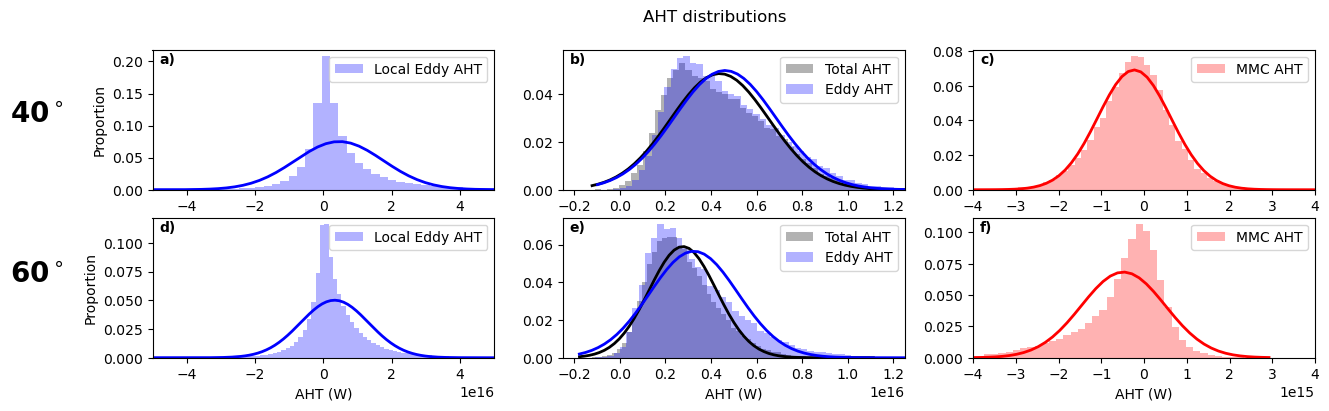

In [17]:
fig, axs = plt.subplots(2, 3, figsize=(15,4))

#eddy_zonal1 = aht_ds.eddy_aht.sel(latitude=which_lat1).values.flatten()
#eddy_zonal2 = aht_ds.eddy_aht.sel(latitude=which_lat2).values.flatten()
#eddy_zonal1 = aht_ds.eddy_aht_no_seasons.sel(latitude=which_lat1).values.flatten()
#eddy_zonal2 = aht_ds.eddy_aht_no_seasons.sel(latitude=which_lat2).values.flatten()

total_color = 'k'
eddy_color ='b'
mmc_color = 'r'

zonal_total_aht1 = aht_ds.total_aht.sel(latitude=which_lat1).values.flatten()
zonal_eddy_aht1 = aht_ds.eddy_aht.sel(latitude=which_lat1).values.flatten()
zonal_mmc_aht1 = aht_ds.mmc_aht.sel(latitude=which_lat1).values.flatten()

era_fncts.plot_hist_and_gauss(axs[0,0], eddy_local1, eddy_color, which_bins=200,
                            label='Local Eddy AHT')
era_fncts.plot_hist_and_gauss(axs[0,1], zonal_total_aht1, total_color,
                            label='Total AHT')
era_fncts.plot_hist_and_gauss(axs[0,1], zonal_eddy_aht1, eddy_color,
                            label='Eddy AHT')
era_fncts.plot_hist_and_gauss(axs[0,2], zonal_mmc_aht1, mmc_color,
                            label='MMC AHT')

zonal_total_aht2 = aht_ds.total_aht.sel(latitude=which_lat2).values.flatten()
zonal_eddy_aht2 = aht_ds.eddy_aht.sel(latitude=which_lat2).values.flatten()
zonal_mmc_aht2 = aht_ds.mmc_aht.sel(latitude=which_lat2).values.flatten()

era_fncts.plot_hist_and_gauss(axs[1,0], eddy_local2, eddy_color, which_bins=200,
                            label='Local Eddy AHT')
era_fncts.plot_hist_and_gauss(axs[1,1], zonal_total_aht2, total_color,
                            label='Total AHT')
era_fncts.plot_hist_and_gauss(axs[1,1], zonal_eddy_aht2, eddy_color,
                            label='Eddy AHT')
era_fncts.plot_hist_and_gauss(axs[1,2], zonal_mmc_aht2, mmc_color,
                            label='MMC AHT')


axs[0,0].legend(loc=1)
axs[1,0].legend(loc=1)
axs[0,1].legend(loc=1)
axs[1,1].legend(loc=1)
axs[0,2].legend(loc=1)
axs[1,2].legend(loc=1)

#axs[0,0].set_yscale('log')
#axs[0,0].set_ylim([1e-6, 1])
#axs[0,0].set_yticks([1e-6, 1e-4, 1e-2, 1e0])
#axs[0,0].set_ylim([0, 0.3])
#axs[1,0].set_yscale('log')
#axs[1,0].set_ylim([1e-6, 1])
#axs[1,0].set_yticks([1e-6, 1e-4, 1e-2, 1e0])
#axs[1,0].set_ylim([0, 0.3])

axs[0,0].set_xlim([-0.5e17, 0.5e17])
axs[1,0].set_xlim([-0.5e17, 0.5e17])
axs[0,1].set_xlim([-0.25e16, 1.25e16])
axs[1,1].set_xlim([-0.25e16, 1.25e16])
axs[0,2].set_xlim([-4e15, 4e15])
axs[1,2].set_xlim([-4e15, 4e15])
#n_bins12, bin_edges12 = np.histogram(eddy_zonal2, num_bins)

#era_fncts.plot_hist_and_gauss(axs[1,2], eddy_local2_decor_samples.flatten(), local_color,
                             # which_bins=bin_edges12, label='Local AHT w/ decorr scale')
#era_fncts.plot_hist_and_gauss(axs[1,2], eddy_zonal2, zonal_color,
                              #which_bins=bin_edges12, label='Zonal AHT')

plt.suptitle('AHT distributions')

axs[0,0].set_ylabel('Proportion')
axs[1,0].set_ylabel('Proportion')

axs[1,0].set_xlabel('AHT (W)')
axs[1,1].set_xlabel('AHT (W)')
axs[1,2].set_xlabel('AHT (W)')

subplot_labels = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)']

for idx, ax in enumerate(axs.flatten()):
    ax.text(x=0.02, y=0.9, s=subplot_labels[idx], transform=ax.transAxes, fontweight='bold')
    
fig.text(x=.03, y=0.7, s='40$^\circ$', fontsize=20, fontweight='bold')
fig.text(x=.03, y=0.3, s='60$^\circ$', fontsize=20, fontweight='bold')
#plt.savefig('figures/4_12_22_meeting/local_zonal_aht_distributions_norm_scale')

plt.show()

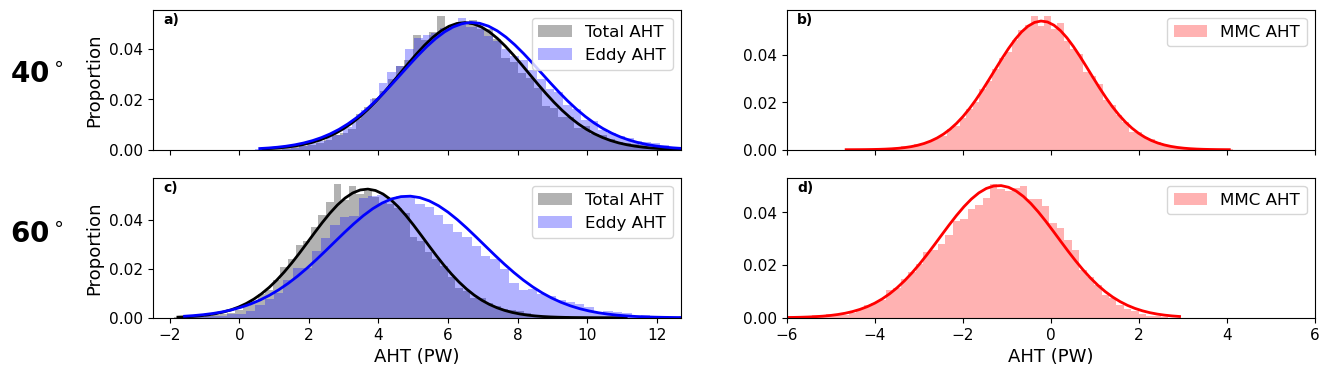

In [28]:
fig, axs = plt.subplots(2, 2, figsize=(15,4))

#eddy_zonal1 = aht_ds.eddy_aht.sel(latitude=which_lat1).values.flatten()
#eddy_zonal2 = aht_ds.eddy_aht.sel(latitude=which_lat2).values.flatten()
#eddy_zonal1 = aht_ds.eddy_aht_no_seasons.sel(latitude=which_lat1).values.flatten()
#eddy_zonal2 = aht_ds.eddy_aht_no_seasons.sel(latitude=which_lat2).values.flatten()

total_color = 'k'
eddy_color ='b'
mmc_color = 'r'

zonal_total_aht1 = era_fncts.get_djf_data(aht_ds.total_aht.sel(latitude=which_lat1).values).flatten()
zonal_eddy_aht1 = era_fncts.get_djf_data(aht_ds.eddy_aht.sel(latitude=which_lat1).values).flatten()
zonal_mmc_aht1 = era_fncts.get_djf_data(aht_ds.mmc_aht.sel(latitude=which_lat1).values).flatten()

era_fncts.plot_hist_and_gauss(axs[0,0], zonal_total_aht1/1e15, total_color,
                            label='Total AHT')
era_fncts.plot_hist_and_gauss(axs[0,0], zonal_eddy_aht1/1e15, eddy_color,
                            label='Eddy AHT')
era_fncts.plot_hist_and_gauss(axs[0,1], zonal_mmc_aht1/1e15, mmc_color,
                            label='MMC AHT')

zonal_total_aht2 = era_fncts.get_djf_data(aht_ds.total_aht.sel(latitude=which_lat2).values).flatten()
zonal_eddy_aht2 = era_fncts.get_djf_data(aht_ds.eddy_aht.sel(latitude=which_lat2).values).flatten()
zonal_mmc_aht2 = era_fncts.get_djf_data(aht_ds.mmc_aht.sel(latitude=which_lat2).values).flatten()

era_fncts.plot_hist_and_gauss(axs[1,0], zonal_total_aht2/1e15, total_color,
                            label='Total AHT')
era_fncts.plot_hist_and_gauss(axs[1,0], zonal_eddy_aht2/1e15, eddy_color,
                            label='Eddy AHT')
era_fncts.plot_hist_and_gauss(axs[1,1], zonal_mmc_aht2/1e15, mmc_color,
                            label='MMC AHT')


axs[0,0].legend(loc=1, fontsize=12)
axs[1,0].legend(loc=1, fontsize=12)
axs[0,1].legend(loc=1, fontsize=12)
axs[1,1].legend(loc=1, fontsize=12)


#axs[0,0].set_yscale('log')
#axs[0,0].set_ylim([1e-6, 1])
#axs[0,0].set_yticks([1e-6, 1e-4, 1e-2, 1e0])
#axs[0,0].set_ylim([0, 0.3])
#axs[1,0].set_yscale('log')
#axs[1,0].set_ylim([1e-6, 1])
#axs[1,0].set_yticks([1e-6, 1e-4, 1e-2, 1e0])
#axs[1,0].set_ylim([0, 0.3])


axs[0,0].set_xlim([-2.5, 12.7])
axs[1,0].set_xlim([-2.5, 12.7])
axs[0,1].set_xlim([-6, 6])
axs[1,1].set_xlim([-6, 6])
#n_bins12, bin_edges12 = np.histogram(eddy_zonal2, num_bins)

#era_fncts.plot_hist_and_gauss(axs[1,2], eddy_local2_decor_samples.flatten(), local_color,
                             # which_bins=bin_edges12, label='Local AHT w/ decorr scale')
#era_fncts.plot_hist_and_gauss(axs[1,2], eddy_zonal2, zonal_color,
                              #which_bins=bin_edges12, label='Zonal AHT')


axs[0,0].set_ylabel('Proportion', fontsize=13)
axs[1,0].set_ylabel('Proportion', fontsize=13)

axs[1,0].set_xlabel('AHT (PW)', fontsize=13)
axs[1,1].set_xlabel('AHT (PW)', fontsize=13)

axs[0,0].set_xticklabels(labels=[], fontsize=11)
axs[0,0].tick_params(axis='y', which='major', labelsize=11)

axs[0,1].set_xticklabels(labels=[], fontsize=11)
axs[0,1].tick_params(axis='y', which='major', labelsize=11)

axs[1,0].tick_params(axis='both', which='major', labelsize=11)
axs[1,1].tick_params(axis='both', which='major', labelsize=11)

subplot_labels = ['a)', 'b)', 'c)', 'd)']

for idx, ax in enumerate(axs.flatten()):
    ax.text(x=0.02, y=0.9, s=subplot_labels[idx], transform=ax.transAxes, fontweight='bold')
    
fig.text(x=.03, y=0.7, s='40$^\circ$', fontsize=20, fontweight='bold')
fig.text(x=.03, y=0.3, s='60$^\circ$', fontsize=20, fontweight='bold')
#plt.savefig('../figures/4_12_22_meeting/local_zonal_aht_distributions_norm_scale_djf_only')

plt.show()

In [12]:
def get_top_5_gaus(datas):   
    
    n_samples = 5000000
    
    mu = np.mean(datas)
    sigma = np.std(datas)
    
    gaus_samples = np.random.normal(mu, sigma, n_samples)
    
    if mu > 0:
        gaus_samples_sorted = np.sort(gaus_samples)
        new_gaus_samples = gaus_samples[gaus_samples>0]
    elif mu <= 0:
        gaus_samples_sorted = np.sort(gaus_samples)[::-1]
        new_gaus_samples = gaus_samples[gaus_samples<0]
    
    top_5_perc = np.sum(gaus_samples_sorted[int(len(gaus_samples_sorted) * 0.95):]) / np.sum(new_gaus_samples)
    
    return top_5_perc

In [13]:
def top_5_perc(datas):
    '''Calculate the contribution from the top 5% of events
    '''

    datas = datas.flatten()
    
    if np.mean(datas) > 0:
        sorted_datas = np.sort(datas)
        new_datas = datas[datas>0]
    elif np.mean(datas) <= 0:
        sorted_datas = np.sort(datas)[::-1]
        new_datas = datas[datas<0]
    
    top_5 = sorted_datas[int(0.95 * len(datas)):]

    
    top_5_perc = np.sum(top_5) / np.sum(new_datas)
    
    return top_5_perc

#field_stats = zonal_total_aht2.flatten()
field_stats = era_fncts.get_djf_data(aht_ds.mmc_aht.sel(latitude=which_lat2).values).flatten()
#field_stats = era_fncts.get_djf_data(eddy_local2).flatten()

print('Mean is: ' + "{:.3e}".format(np.mean(field_stats)))
print('Std. Dev. is: ' + "{:.3e}".format(np.std(field_stats)))
print('Skew is: ' + "{:.3e}".format(sc.skew(field_stats)))
print('Kurtosis is: ' + "{:.3e}".format(sc.kurtosis(field_stats)))
print('Top 5% of events contribute: ' + str(round(100 * top_5_perc(field_stats), 1)))
print('Top 5% of gaussian events contribute: ' + str(round(100 * get_top_5_gaus(field_stats), 1)))

Mean is: -1.179e+15
Std. Dev. is: 1.342e+15
Skew is: -3.043e-01
Kurtosis is: 1.010e-01
Top 5% of events contribute: 15.9
Top 5% of gaussian events contribute: 15.0
